<a href="https://colab.research.google.com/github/antonsysoev/DeepLearning/blob/main/Autotranslate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# seq2seq модели 


In [27]:
import matplotlib.pyplot as plt

import re
import numpy as np
import os
import time

import tensorflow as tf
print(tf.__version__)

2.11.0


# 1. Подготовка даных 

Мы будем использовать датасет переводов из базы данных http://www.manythings.org/anki/. Кроме всего прочего, можно найти подобные датасеты среди [стенограмм ООН](https://catalog.ldc.upenn.edu/LDC2013T06) и [Европейского союза.](http://www.statmt.org/europarl/) 

Скачаем датасет `rus-eng.zip` и положим его рядом с питоновской тетрадкой.

In [28]:
!wget http://www.manythings.org/anki/rus-eng.zip

--2023-03-23 17:08:48--  http://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15374406 (15M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  14.66M  8.53MB/s    in 1.7s    

2023-03-23 17:08:50 (8.53 MB/s) - ‘rus-eng.zip’ saved [15374406/15374406]



In [29]:
!unzip rus-eng.zip

Archive:  rus-eng.zip
replace rus.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: rus.txt                 
  inflating: _about.txt              


In [30]:
!rm rus-eng.zip

In [31]:
!ls

_about.txt  rus.txt  sample_data  training_checkpoints


In [32]:
!head rus.txt 

Go.	Марш!	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1159202 (shanghainese)
Go.	Иди.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5898247 (marafon)
Go.	Идите.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5898250 (marafon)
Hi.	Здравствуйте.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #402127 (odexed)
Hi.	Привет!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #466968 (katjka)
Hi.	Хай.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #467233 (timsa)
Hi.	Здрасте.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #3803577 (marafon)
Hi.	Здоро́во!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #3854188 (marafon)
Hi.	Приветик!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #7234283 (marafon)
Run!	Беги!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #1569978 (Biga)


Внутри файла `rus.txt` лежат пары для перевода в формате: 

```
Get down!	Ляг на пол!
```

Нам нужно предобработать датасет. Поступим с ним следующим образом:

- Добавим токены `<start>` и `<end>`, сигнализирующие о начале и конце предложения. 
- Отделим знаки препинания от основного текста.

Например, строка `'Run!	Беги!'` должна превратиться в `'<start> run ! <end>', '<start> беги ! <end>'`.

In [33]:
def preprocess_sentence(w):
    """
        Функция для предобработки 
    """
    
    # уменьшаем регистр и убираем лишние пробелы
    w = w.lower().strip()

    # делаем между словом и знаком пунктуации отступ 'привет! -> привет !'
    w = re.sub(r"([?.!,])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # выкидываем все остальные символы из рассмотрения 
    w = re.sub(r"[^a-яА-Яa-zA-Z?.!,]+", " ", w)
    w = w.rstrip().strip()
    
    # добавляем токены для начала и конца предложения
    w = '<start> ' + w + ' <end>'
    return w


def create_dataset(path, num_examples):
    """
        Функция, которая создаёт датасет
    """
    lines = open(path).read().strip().split('\n')
    
    word_pairs = [[preprocess_sentence(w)
                   for w in l.split('CC-BY 2.0')[0].strip().split('\t')]  for l in lines[:num_examples]]
    
    return word_pairs

In [34]:
# Пример работы предобработчика :3 
create_dataset('rus.txt', 10)

[['<start> go . <end>', '<start> марш ! <end>'],
 ['<start> go . <end>', '<start> иди . <end>'],
 ['<start> go . <end>', '<start> идите . <end>'],
 ['<start> hi . <end>', '<start> здравствуйте . <end>'],
 ['<start> hi . <end>', '<start> привет ! <end>'],
 ['<start> hi . <end>', '<start> хай . <end>'],
 ['<start> hi . <end>', '<start> здрасте . <end>'],
 ['<start> hi . <end>', '<start> здоро́во ! <end>'],
 ['<start> hi . <end>', '<start> приветик ! <end>'],
 ['<start> run ! <end>', '<start> беги ! <end>']]

- Создадим два словарика вида `id -> word` и `word -> id`. Напишем для этой затеи удобный класс. 

In [35]:
class LanguageIndex():
    """
        Класс для строительства мапинга 
            индекс -> слово и слово -> индекс
        для каждого из языков 
    """
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))

        self.vocab = sorted(self.vocab)

        self.word2idx['<pad>'] = 0
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1

        for word, index in self.word2idx.items():
            self.idx2word[index] = word


- Осталось выравнять все тексты в батче, пришедшем к нам на вход до одной длины. Сделаем Padding всех предложений к одной длине с помощью фиктивного символа. 

In [36]:
def get_max_length(tensor):
    """
        Максимальная длина предложения в тензоре 
    """
    return max(len(t) for t in tensor)


def load_dataset(path, num_examples):
    """
        Функция, которая полностью готовит данные для сетки 
    """
    
    # подгрузка данных и их предобработка 
    pairs = create_dataset(path, num_examples)

    # создаём два экземпляра со словарями и индексами 
    inp_lang = LanguageIndex(ru for en, ru in pairs)
    targ_lang = LanguageIndex(en for en, ru in pairs)
    
    # Векторизуем данные в соотвествии с нашими классами 
    # Русские предложения
    input_tensor = [[inp_lang.word2idx[s] for s in ru.split(' ')] for en, ru in pairs]
    
    # Английские предложения
    target_tensor = [[targ_lang.word2idx[s] for s in en.split(' ')] for en, ru in pairs]
    
    # Находим максимальные длинны для каждого языка
    max_length_inp, max_length_tar = get_max_length(input_tensor), get_max_length(target_tensor)
    
    # Заполняем у всех других предложений пропуски падингами до максимальной длины 
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=max_length_inp,
                                                                 padding='post')
    
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=max_length_tar, 
                                                                  padding='post')
    
    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

Для того, чтобы эксперимент с обучением нейронной сетки прошёл побыстрее, ограничимся корпусом из $30000$ предложений. В домашних условиях вы можете попробовать обучить модель на всём корпусе.

In [37]:
from sklearn.model_selection import train_test_split


In [38]:
path_to_file = '/content/rus.txt'
num_examples = 30000

input_tensor, target_tensor, inp_lang, targ_lang, \
    max_length_inp, max_length_targ = load_dataset(path_to_file, num_examples)

In [39]:
input_tensor # вход! 

array([[   5, 3483,    1, ...,    0,    0,    0],
       [   5, 2661,    3, ...,    0,    0,    0],
       [   5, 2670,    3, ...,    0,    0,    0],
       ...,
       [   5, 6618, 3608, ...,    0,    0,    0],
       [   5, 6619, 3608, ...,    0,    0,    0],
       [   5, 6618, 3608, ...,    0,    0,    0]], dtype=int32)

In [40]:
target_tensor # выход!

array([[   5, 1332,    3, ...,    0,    0,    0],
       [   5, 1332,    3, ...,    0,    0,    0],
       [   5, 1332,    3, ...,    0,    0,    0],
       ...,
       [   5,  428, 1909, ...,    4,    0,    0],
       [   5,  428, 1909, ...,    4,    0,    0],
       [   5,  428, 1909, ...,    4,    0,    0]], dtype=int32)

In [41]:
max_length_inp, max_length_targ

(12, 9)

In [42]:
# Дробим выборку на тренировочную и тестовую 
input_tensor_train, input_tensor_val, \
target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(24000, 24000, 6000, 6000)

Отлично! Осталя последний штрих.

In [43]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE // BATCH_SIZE

embedding_dim = 256
units = 1024

vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)


In [44]:
dataset

<BatchDataset element_spec=(TensorSpec(shape=(64, 12), dtype=tf.int32, name=None), TensorSpec(shape=(64, 9), dtype=tf.int32, name=None))>

# 2. Архитектура сетки

Давайте реализуем автокодировщик с вниманием. 

<img src="https://raw.githubusercontent.com/tensorflow/nmt/master/nmt/g3doc/img/encdec.jpg" width="500" alt="attention mechanism">

Более подробно, каждая часть - рекурентная сетка: 

<img src="https://raw.githubusercontent.com/tensorflow/nmt/master/nmt/g3doc/img/seq2seq.jpg" width="500" alt="attention mechanism">

Применение: 

<img src="https://raw.githubusercontent.com/tensorflow/nmt/master/nmt/g3doc/img/greedy_dec.jpg" width="350" alt="attention mechanism">

Вариант архитектуры с вниманием: 

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

Каждое предложение на входе трансформируется в скрытое представление, по которому сетка пытается построить такое же предложение на другом языке.

In [45]:
# как отдельная функция, чтобы ваше внимание обратить
def gru(units):
    """
        GRU-ячейка 
    """
    return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')

In [46]:
class Encoder(tf.keras.Model):
    """
        Наш энкодер 
    """
    
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        
        # фактически мы будем учит на входе эмбединг
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        
        # а после к этому эмбедингу применять рекурентность
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [47]:
class Decoder(tf.keras.Model):
    """
        Наш декодер
    """
    
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # Веса для внимания
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [48]:
# Объединяем две сетки в одну цельную архитектуру 
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

Теперь оптимизатор и функция потерь.

In [49]:
optimizer = tf.optimizers.Adam()  # АДАМ для градиентного спуска 

# В качестве функции потерь будет обычная кросс-энтропия на все наши классы (слова)
def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)

Заведём специальную директорию для автосохранений по мере обучения. Комп может зависать и вырубаться, а прогресс терять на очень хочется. 

In [50]:
checkpoint_dir = './training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

# 3. Обучение 

1. Прокручиваем *input* через  энкодер, получаем *encoder output* и *encoder hidden state*.
2. Прогоняем через декодер *encoder output*, *encoder hidden state* и *decoder input* 
3. Декодер нам выдаёт *predictions*
4. Расчитываем logloss, градиенты и делаем backprop

In [51]:
EPOCHS = 2

for epoch in range(EPOCHS):
    start = time.time()
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)       
            
            for t in range(1, targ.shape[1]):
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
                
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        batch_loss = (loss / int(targ.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.8903
Epoch 1 Batch 100 Loss 2.1594
Epoch 1 Batch 200 Loss 1.7919
Epoch 1 Batch 300 Loss 1.4100
Epoch 1 Loss 1.8846
Time taken for 1 epoch 1521.9286661148071 sec

Epoch 2 Batch 0 Loss 1.3914
Epoch 2 Batch 100 Loss 1.2759
Epoch 2 Batch 200 Loss 1.1604
Epoch 2 Batch 300 Loss 1.1384
Epoch 2 Loss 1.2099
Time taken for 1 epoch 1446.1637716293335 sec



# 4. Переводим 

In [52]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word2idx[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [53]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [54]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Восстанавливаем последний чекпойнт и тестируем модель. 

In [55]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> я люблю тебя <end>
Predicted translation: i love you . <end> 


<ipython-input-53-219babc300ac>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-53-219babc300ac>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


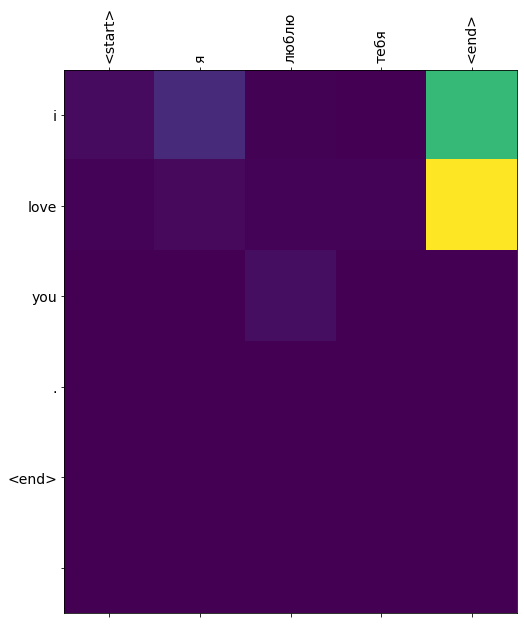

In [60]:
translate('Я люблю тебя', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> я правда люблю тебя . <end>
Predicted translation: i love you . <end> 


<ipython-input-53-219babc300ac>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-53-219babc300ac>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


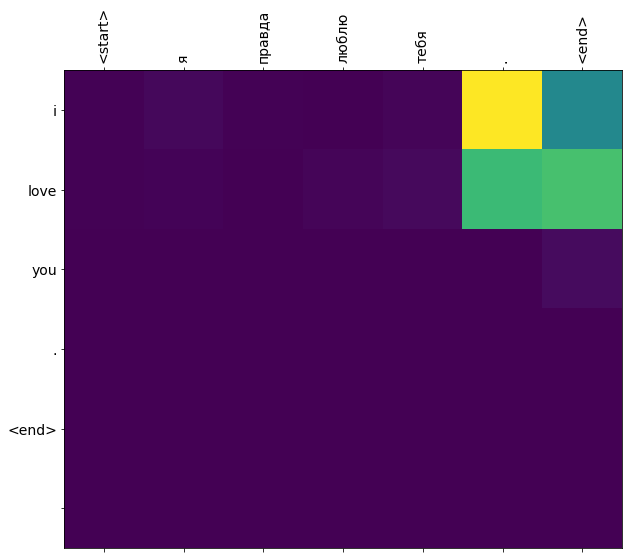

In [57]:
translate('Я правда люблю тебя.', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> я люблю тебя , правда . <end>
Predicted translation: i love you . <end> 


<ipython-input-53-219babc300ac>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-53-219babc300ac>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


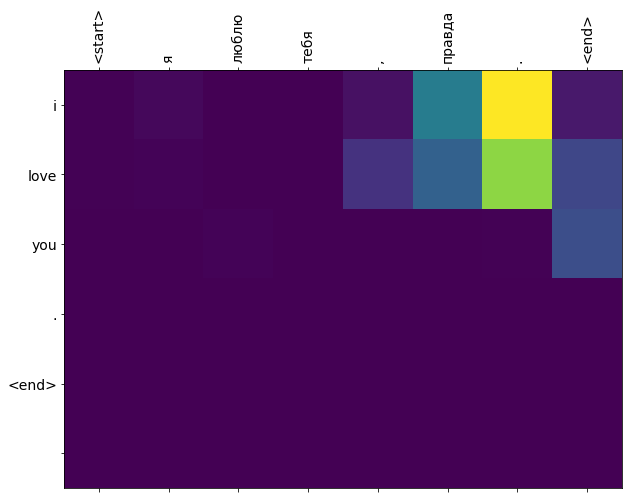

In [58]:
translate('Я люблю тебя, правда.', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> ты правда меня любишь ? <end>
Predicted translation: do you hear me ? <end> 


<ipython-input-53-219babc300ac>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-53-219babc300ac>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


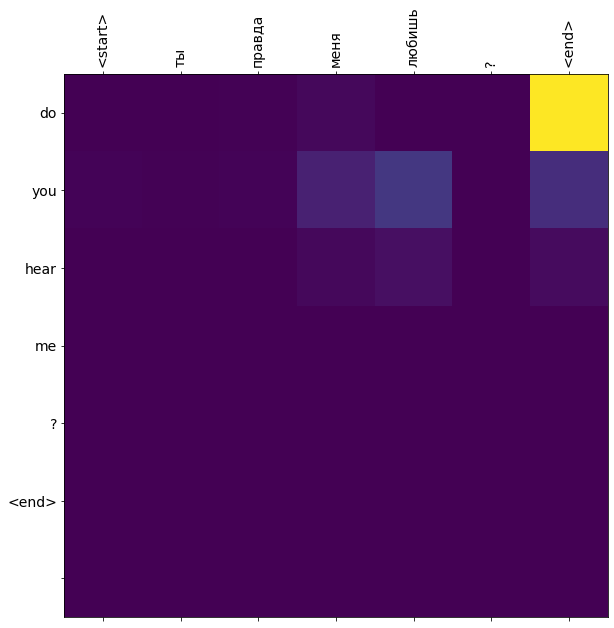

In [59]:
# wrong translation
translate('Ты правда меня любишь?', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)